Alan Patricio González Bernal - A01067546
Entrega Mid-Term de modelo Wa-Tor


Introducción
Wa-Tor es una simulación de peces contra tiburones en un mundo toroidal. Fue diseñado por AK Dewdney en 1984 y publicado en Scientific American bajo el nombre “Tiburones y peces libran una guerra ecológica en el planeta toroidal Wa-Tor”.

Tu reto será repetir esta simulación. Así de sencillo.

Descripción
El mundo de Wa-Tor consiste en una cuadrícula bidimensional de celdas que pueden estar vacías, contener un pez o contener un tiburón. La cuadrícula se envuelve de arriba a abajo y de izquierda a derecha, por lo que también se puede considerar como un toroide (de ahí Wa-Tor).

El tiempo avanza en pasos discretos, llamados cronones. En cada cronón, el estado de cada criatura evoluciona de acuerdo con las siguientes reglas:

Todas las criaturas empiezan en una celda vacía;
Cada pez se mueve aleatoriamente a una celda adyacente (usando un vecindario de von Neumann de celdas vecinas directamente al norte, sur, este y oeste); si las celdas están todas ocupadas, no se mueve;
Después de que un pez ha sobrevivido un número fijo de cronones (fertility_threshold), se reproduce dejando otro pez atrás en su celda anterior después de moverse. Posteriormente, su fertilidad se pone a cero;
Después de cada cronón, cada pez pierde una unidad de energía. Si la energía de un pez llega a cero, muere;
Cada tiburón se mueve aleatoriamente a una celda adyacente (usando un vecindario de von Neumann de celdas vecinas directamente al norte, sur, este y oeste) ocupada por un pez y gana una cierta cantidad de energía al hacerlo (al "comerse" el pez); si las celdas adyacentes están todas vacías, se mueve a una de ellas al azar; si las celdas adyacentes están llenas de tiburones, no se mueve;
Después de cada cronón, cada tiburón pierde una unidad de energía. Si la energía de un tiburón llega a cero, muere;
Una vez que un tiburón alcanza su propio umbral de fertilidad, se reproduce de la misma manera que los peces.
Parámetros de la simulación
Wa-Tor está controlado por los siguientes parámetros:

Tamaño del mundo: 75 x 50.
Cantidad de peces: 120
Cantidad de tiburones: 40
Energía inicial de los peces: 20
Energía inicial de los tiburones: 3
Umbral de fertilidad de los peces (fertility_threshold): 4
Umbral de fertilidad de los tiburones (fertility_threshold): 12

In [480]:
# Se generan los imports, los mismos que el segregation model
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''Simultaneousctivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import SimultaneousActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime


In [481]:
# Voy a tratar de rehacer los agentes en este bloque, quiero poder comprenderlo al 100% y rectificar errores, pero no borro el otro agente para no perderlo.
class FishAgent(Agent):
    def __init__(self, current_id, model, energy, fertility = 0):
        super().__init__(current_id, model)
        self.energy = energy
        self.fertility = fertility
        
    def step(self):
        self.advance()
        
    def move(self):
        # Vamos a definir los movimientos posibles para que concuerde con lo del vecindario de Vonn Newmann.
        possible_moves = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        # Vamos a eliminar de possible moves los espacios utilizados
        empty_cells = [cell for cell in possible_moves if self.model.grid.is_cell_empty(cell)]
        
        # Ahora si, hacemos el movimiento aleatorio.
        if empty_cells:
            new_position = self.random.choice(empty_cells)
            self.model.grid.move_agent(self, new_position)
            
        else:
            return  None
        
    def advance(self):
        self.move()
        self.energy -= 1
        if self.energy <= 0:
            self.model.grid.remove_agent(self.pos)
            self.model.schedule.remove(self)
        else:
            if self.fertility == 4:
                self.reproduce()
            else:
                self.fertility += 1
    
    def reproduce(self, fertility_threshold=4):
        if self.fertility == fertility_threshold:
            # Recordar la posición actual del agente padre
            current_position = self.pos
            
            empty_cells = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
            empty_cells = [cell for cell in empty_cells if self.model.grid.is_cell_empty(cell)]
            
            if empty_cells:
                new_position = self.random.choice(empty_cells)
                self.model.grid.move_agent(self, new_position)
                energy_of_offspring = 20
                offspring = FishAgent(self.model.next_id(), self.model, energy=energy_of_offspring, fertility=0)
                self.model.grid.place_agent(offspring, current_position)  # Colocar el offspring en la posición anterior del padre
                self.model.schedule.add(offspring)
                
                self.fertility = 0
                
            else:
                return  None
        else:
            return  None

            
class SharkAgent(Agent):
    def __init__(self, current_id, model, energy, fertility = 0):
        super().__init__(current_id, model)
        self.energy = energy
        self.fertility = fertility
        
    def step(self):
        self.advance()
    
    def move(self):
        # Vamos a definir los movimientos posibles para que concuerde con lo del vecindario de Vonn Newmann.
        possible_moves = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        # Vamos a eliminar de possible moves los espacios utilizados
        empty_cells = [cell for cell in possible_moves if self.model.grid.is_cell_empty(cell)]
        
        # Ahora si, hacemos el movimiento aleatorio.
        if empty_cells:
            new_position = self.random.choice(empty_cells)
            self.model.grid.move_agent(self, new_position)
            
        else:
            return None
            
    def advance(self):
        self.energy -= 1
        if self.energy <= 0:
            self.model.grid.remove_agent(self.pos)
            self.model.schedule.remove(self)
        else:
            if self.fertility == 12:
                self.reproduce()
            else:
                self.fertility += 1
        self.move()
                
    def reproduce(self, fertility_threshold=12):
        if self.fertility == fertility_threshold:
            # Recordar la posición actual del agente padre
            current_position = self.pos
            
            empty_cells = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
            empty_cells = [cell for cell in empty_cells if self.model.grid.is_cell_empty(cell)]
            
            if empty_cells:
                new_position = self.random.choice(empty_cells)
                self.model.grid.move_agent(self, new_position)
                energy_of_offspring = 3
                offspring = FishAgent(self.model.next_id(), self.model, energy=energy_of_offspring, fertility=0)
                self.model.grid.place_agent(offspring, current_position)  # Colocar el offspring en la posición anterior del padre
                self.model.schedule.add(offspring)
                
                self.fertility = 0
                
            else:
                return None
        else:
            return  None

    
    def eat(self, energy_gain_from_food = 20):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        fish = [obj for obj in cellmates if isinstance(obj, FishAgent)]
        if len(fish) > 0:
            prey = self.random.choice(fish)
            self.model.grid.remove_agent(self.pos)
            self.model.schedule.remove(prey)
            self.energy += energy_gain_from_food

In [482]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height, 3))  # Usamos una matriz de 3 dimensiones para almacenar colores
    
    for cell in model.grid.coord_iter():
        cell_content, (x, y) = cell
        if cell_content is not None:
            cell_agent = cell_content
            if isinstance(cell_agent, FishAgent):
                grid[x][y] = [1, 0, 0]  # Rojo para los peces
            elif isinstance(cell_agent, SharkAgent):
                grid[x][y] = [0, 0, 1]  # Azul para los tiburones
        else:
            grid[x][y] = [1, 1, 1]  # Blanco para los espacios vacíos
                
    return grid

In [483]:
class WaTorModel(Model):
    def __init__(self, width, height, initial_fish, initial_sharks):
        self.num_agents = initial_fish + initial_sharks
        self.grid = SingleGrid(width, height, torus=True)
        self.schedule = SimultaneousActivation(self)  
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        self.initial_fish = initial_fish
        self.initial_sharks = initial_sharks
        self.current_id = 0  
        
        num_fish = int((initial_fish / self.num_agents) * (self.grid.width * self.grid.height))
        while self.grid.exists_empty_cells() and num_fish > 0:
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            if self.grid.is_cell_empty((x, y)):
                energy_of_fish = 20
                fertility_of_fish = 0
                fish = FishAgent(self.next_id(), self, energy=energy_of_fish, fertility=fertility_of_fish)
                self.grid.place_agent(fish, (x, y))
                self.schedule.add(fish)
                num_fish -= 1
        num_sharks = int((initial_sharks / self.num_agents) * (self.grid.width * self.grid.height))
        while self.grid.exists_empty_cells() and num_sharks > 0:
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            if self.grid.is_cell_empty((x, y)):
                energy_of_shark = 3
                fertility_of_shark = 0
                shark = SharkAgent(self.next_id(), self, energy=energy_of_shark, fertility=fertility_of_shark)
                self.grid.place_agent(shark, (x, y))
                self.schedule.add(shark)
                num_sharks -= 1
                
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
    

In [484]:
# Parámetros del modelo
GRID_WIDTH = 75
GRID_HEIGHT = 50
INITIAL_FISH = 20
INITIAL_SHARKS = 20
MAX_GENERATIONS = 1

# Crear el modelo
model = WaTorModel(GRID_WIDTH, GRID_HEIGHT, INITIAL_FISH, INITIAL_SHARKS)

# Ejecutar simulación
for i in range(MAX_GENERATIONS):
    model.step()


In [485]:
all_grid = model.datacollector.get_model_vars_dataframe()

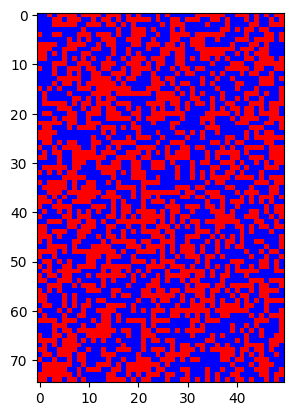

In [486]:
colored_grid = get_grid(model)

# Mostrar la grilla usando matplotlib
plt.imshow(colored_grid)
plt.show()